<a href="https://colab.research.google.com/github/ivan890617/Cluster-practice/blob/main/LSTM_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Read the data & Data preprocessing

In [18]:
!wget https://raw.githubusercontent.com/ivan890617/Cluster-practice/main/result.csv

--2022-04-23 07:38:04--  https://raw.githubusercontent.com/ivan890617/Cluster-practice/main/result.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4777851 (4.6M) [text/plain]
Saving to: ‘result.csv’

result.csv          100%[===================>]   4.56M  --.-KB/s    in 0.08s   

2022-04-23 07:38:04 (57.7 MB/s) - ‘result.csv’ saved [4777851/4777851]



In [19]:
data = pd.read_csv("result.csv")
data["Datetime"] = pd.to_datetime(data["Datetime"])
data_sort = data.sort_values(by='Datetime')
data_sort = pd.DataFrame(data_sort,columns=['Datetime','AEP_MW','sub_label'])
data_sort

,Datetime,AEP_MW,sub_label
0,2004-10-01 01:00:00,12379.0,2
1,2004-10-01 02:00:00,11935.0,2
2,2004-10-01 03:00:00,11692.0,2
3,2004-10-01 04:00:00,11597.0,1
4,2004-10-01 05:00:00,11681.0,2
...,...,...,...
125356,2018-08-02 20:00:00,17673.0,7
125357,2018-08-02 21:00:00,17303.0,6
125358,2018-08-02 22:00:00,17001.0,6
125359,2018-08-02 23:00:00,15964.0,5


set the label from 1-9 to 0-8 

In [5]:
data_sort["sub_label"] = data_sort["sub_label"] -1
data_sort

,Datetime,AEP_MW,sub_label
0,2004-10-01 01:00:00,12379.0,1
1,2004-10-01 02:00:00,11935.0,1
2,2004-10-01 03:00:00,11692.0,0
3,2004-10-01 04:00:00,11597.0,0
4,2004-10-01 05:00:00,11681.0,0
...,...,...,...
121268,2018-08-02 20:00:00,17673.0,6
121269,2018-08-02 21:00:00,17303.0,5
121270,2018-08-02 22:00:00,17001.0,5
121271,2018-08-02 23:00:00,15964.0,4


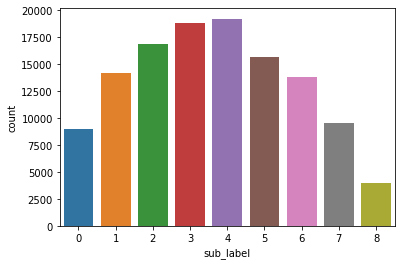

In [8]:
sns.countplot(x=data_sort['sub_label'])

Convert to data that can be used by the model

Give a sliding window,in other words,the model would not only read the instant data,but also read the data in the past.

In [9]:
def sliding_windows(data,label, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = label.iloc[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

normalize the data

In [10]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data_sort[['AEP_MW']])

divide the data into training set and test set

In [11]:
seq_length = 4
x, y = sliding_windows(training_data,data_sort['sub_label'] ,seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
trainY = trainY.long()

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [12]:
print(dataX.shape)
print(dataY.shape)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

torch.Size([121268, 4, 1])
torch.Size([121268])
torch.Size([81249, 4, 1])
torch.Size([81249])
torch.Size([40019, 4, 1])
torch.Size([40019])


# **Define the LSTM model**

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size # 設定越多代表能記住的特徵越多
        self.seq_length = seq_length

        # LSTM layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.3)

         # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):                  # x's shape (batch_size, 序列长度, 序列中每个数据的长度)
        out, _ = self.lstm(x)              # out's shape (batch_size, 序列长度, hidden_dim)
        out = out[:, -1, :]                # 中间的序列长度取-1，表示取序列中的最后一个数据，这个数据长度为hidden_dim，
                                           # 得到的out的shape为(batch_size, hidden_dim)
        out = self.fc(out)             # 经过线性层后，out的shape为(batch_size, n_class)
        return out


# **Start training**

In [14]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1      #input feature size
hidden_size = 64     #hidden layer cell size
num_layers = 2      #hidden layer

num_classes = 9   #output size

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    # 1 將data傳入model進行forward propagation
    # (put data into model and start forward propagation)
    outputs = lstm(trainX)
    # 2 清空前一次的gradient
    # (clean gradient last time)
    optimizer.zero_grad()
    # 3 obtain the loss function
    loss = criterion(outputs, trainY)
    # 4 根據loss進行back propagation，計算gradient
    # (start back propagation based on loss,and calculate gradient)
    loss.backward()
    # 5 做gradient descent
    # (start gradient descent)
    optimizer.step()
    if epoch % 25 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 2.21309
Epoch: 25, loss: 2.12508
Epoch: 50, loss: 2.09305
Epoch: 75, loss: 1.79951
Epoch: 100, loss: 1.68450
Epoch: 125, loss: 1.62939
Epoch: 150, loss: 1.53967
Epoch: 175, loss: 1.40635
Epoch: 200, loss: 1.26831
Epoch: 225, loss: 1.18054
Epoch: 250, loss: 1.12216
Epoch: 275, loss: 1.07874
Epoch: 300, loss: 1.04401
Epoch: 325, loss: 1.03260
Epoch: 350, loss: 0.98520
Epoch: 375, loss: 0.95765
Epoch: 400, loss: 0.93130
Epoch: 425, loss: 0.90490
Epoch: 450, loss: 0.87917
Epoch: 475, loss: 0.85074
Epoch: 500, loss: 0.83690
Epoch: 525, loss: 0.80257
Epoch: 550, loss: 0.78741
Epoch: 575, loss: 0.76558
Epoch: 600, loss: 0.74986
Epoch: 625, loss: 0.73591
Epoch: 650, loss: 0.71824
Epoch: 675, loss: 0.70737
Epoch: 700, loss: 0.69385
Epoch: 725, loss: 0.68271
Epoch: 750, loss: 0.67052
Epoch: 775, loss: 0.65936
Epoch: 800, loss: 0.65084
Epoch: 825, loss: 0.63904
Epoch: 850, loss: 0.62655
Epoch: 875, loss: 0.61849
Epoch: 900, loss: 0.61013
Epoch: 925, loss: 0.59997
Epoch: 950, loss:

# **Start Predict**

[8 7 7 ... 5 5 5]


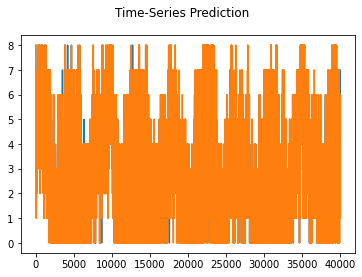

In [15]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
data_predict = np.argmax(data_predict, axis=1)
print(data_predict)

data_predict = pd.DataFrame(data_predict)
data_predict

dataY_plot = testY.data.numpy()

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(testY,data_predict))
print(classification_report(testY,data_predict))
print(accuracy_score(testY,data_predict))

[[4069  657    0    0    0    0    0    0    0]
 [ 402 4866  466    0    0    1    0    0    0]
 [   0  675 5704  550    0    0    0    0    0]
 [   0    0 1193 5002  503    0    0    0    0]
 [   0    1    0  852 3886  307    0    0    0]
 [   0    0    0    0  857 3032  233    0    0]
 [   0    0    0    0    0  605 2886  114    0]
 [   0    0    0    0    0    0  441 1967   39]
 [   0    0    0    0    0    0    0  192  519]]
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88      4726
         1.0       0.78      0.85      0.82      5735
         2.0       0.77      0.82      0.80      6929
         3.0       0.78      0.75      0.76      6698
         4.0       0.74      0.77      0.76      5046
         5.0       0.77      0.74      0.75      4122
         6.0       0.81      0.80      0.81      3605
         7.0       0.87      0.80      0.83      2447
         8.0       0.93      0.73      0.82       711

    accuracy             